In [166]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

In [167]:
with open('./pickles/allPixelNDVIPoly.pickle', 'rb') as handle:
    allPixelNDVIPoly3 = pickle.load(handle)

with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/kmeans_total_3_c2.pickle', 'rb') as handle:
    kmeans_total3 = pickle.load(handle)

In [168]:
# Numero di cluster 

num_cluster = 2

allPixelNDVIPoly3 = allPixelNDVIPoly3[(newResa3<=11000) & (newResa3 >= 4000),:]
newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]

# Andiamo a calcolare una nuova metrica di coesione

In [169]:
km_one3 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one3 = km_one3.fit_predict(allPixelNDVIPoly3)

[0 1]
(1471,)
1471
7708.3


(array([ 1.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  2.,  2.,  0.,  3.,  4.,
         5.,  3.,  2.,  7.,  6., 10.,  4.,  4., 12.,  7., 10., 12.,  4.,
         8.,  9., 11.,  8., 10., 19., 14., 12., 13., 23., 15., 20., 17.,
        16., 31., 28., 21., 39., 27., 32., 18., 42., 25., 30., 31., 31.,
        34., 33., 27., 37., 42., 43., 34., 29., 18., 39., 27., 26., 27.,
        36., 20., 28., 26., 20., 24., 18., 24., 21., 19., 14., 24., 17.,
        13., 16., 16.,  5.,  9., 11.,  9.,  6.,  6.,  3.,  4.,  3.,  3.,
         2.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([ 4026.30004883,  4093.73803711,  4161.17626953,  4228.61425781,
         4296.05224609,  4363.49023438,  4430.92822266,  4498.36621094,
         4565.80419922,  4633.2421875 ,  4700.68017578,  4768.11816406,
         4835.55615234,  4902.99414062,  4970.43212891,  5037.87011719,
         5105.30810547,  5172.74609375,  5240.18408203,  5307.62207031,
         5375.06005859,  5442.49804688,  5509.93603516,  5577.37402344,
  

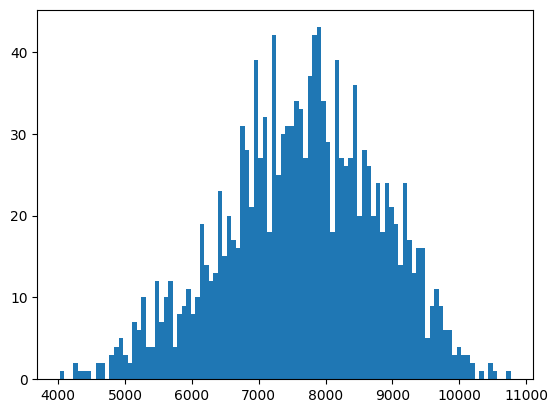

In [170]:
print(np.unique(y_pred_one3))
print(y_pred_one3.shape)
print(newResa3.shape[0])
print(np.median(newResa3))
plt.hist(newResa3,100)

In [171]:
label_3 = np.ndarray([newResa3.shape[0]])

for a,b in zip(newResa3,range(newResa3.shape[0])):
    if(a > np.median(newResa3)):
        label_3[b] = int(0) # resa alta
    else:
        label_3[b] = int(1) # resa bassa

In [172]:
# Associazione del cluster i-esimo con la classe i-esima

list_of_mapping = []

for x in range(0,int(155/5)):

    list_of_mapping.append([])

    for y in range(0,int(155/5)):
        if(kmeans_total3[x,y] is not None):
            cluster_class_mapping = {}
            for cluster in range(0,num_cluster):
                cluster_classes = label_3[kmeans_total3[x,y] == cluster]
                unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
                dominant_class = unique_classes[np.argmax(class_counts)]
                cluster_class_mapping[cluster] = dominant_class
            list_of_mapping[-1].append(cluster_class_mapping)    
        else:
            continue

In [173]:
for a in range(len(list_of_mapping)):
    print(len(list_of_mapping[a]))

30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [174]:
'''difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

for i in range(num_cluster):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)'''

list_of_difference = []

for a in range(len(list_of_mapping)):

    list_of_difference.append([])

    for b in range(len(list_of_mapping[0])):

        difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

        for i in range(num_cluster):
            if(i != cluster_class_mapping[i]):

                new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
                difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)
        
        list_of_difference[-1].append(difference)

In [175]:
print(range(len(kmeans_total3[0,0])))

range(0, 1471)


In [176]:
'''indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_pred_one3))
    if y_pred_one3[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_pred_one3[a] = true_value'''

for x in range(len(list_of_difference)):

    for y in range(len(list_of_difference[x])):

        indici = []

        if(kmeans_total3[x,y] is not None):
            for a in list_of_difference[x][y]['num_cluster']:
                indici.append([
                index for index in range(len(kmeans_total3[x,y]))
                if kmeans_total3[x,y][index] == a
            ])

            for ind,true_value in zip(indici,list_of_difference[x][y]['num_class']):
                for a in ind:
                    kmeans_total3[x,y][a] = true_value

        else:
            continue

In [177]:
# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(num_cluster):
    cluster_samples = allPixelNDVIPoly3[y_pred_one3 == i]
    cluster_classes = label_3[y_pred_one3 == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [178]:
print(cluster_class_mapping)

{0: 1.0, 1: 0.0}


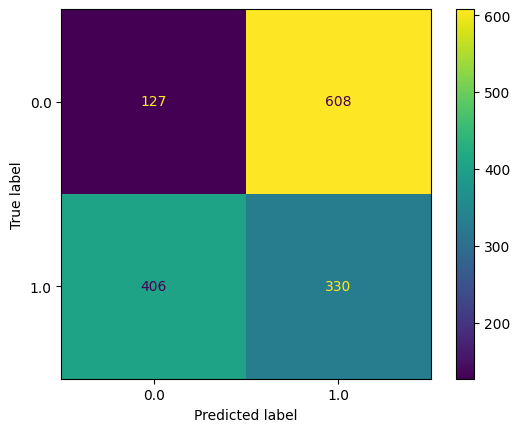

In [179]:
ConfusionMatrixDisplay.from_predictions(label_3,y_pred_one3)
plt.show()

In [180]:
accuracy = str(accuracy_score(label_3,y_pred_one3))
precision = str(precision_score(label_3,y_pred_one3,average= None))
recall = str(recall_score(label_3,y_pred_one3,average= None))

print("accuratezza " + accuracy)
print("precision " + precision)
print("recall " + recall)

accuratezza 0.31067301155676413
precision [0.23827392 0.35181237]
recall [0.17278912 0.44836957]


In [181]:
matrice_precision = np.zeros([int(155/5),int(155/5)])
matrice_recall = np.zeros([int(155/5),int(155/5)])
matrice_accuracy = np.zeros([int(155/5),int(155/5)])

for x in range(0,int(155/5)):

    for y in range(0,int(155/5)):

        if(kmeans_total3[x,y] is not None):
            matrice_precision[x,y] = precision_score(label_3,kmeans_total3[x,y],average= 'macro')
            matrice_recall[x,y] = recall_score(label_3,kmeans_total3[x,y],average= 'macro')
            matrice_accuracy[x,y] = accuracy_score(label_3,kmeans_total3[x,y])

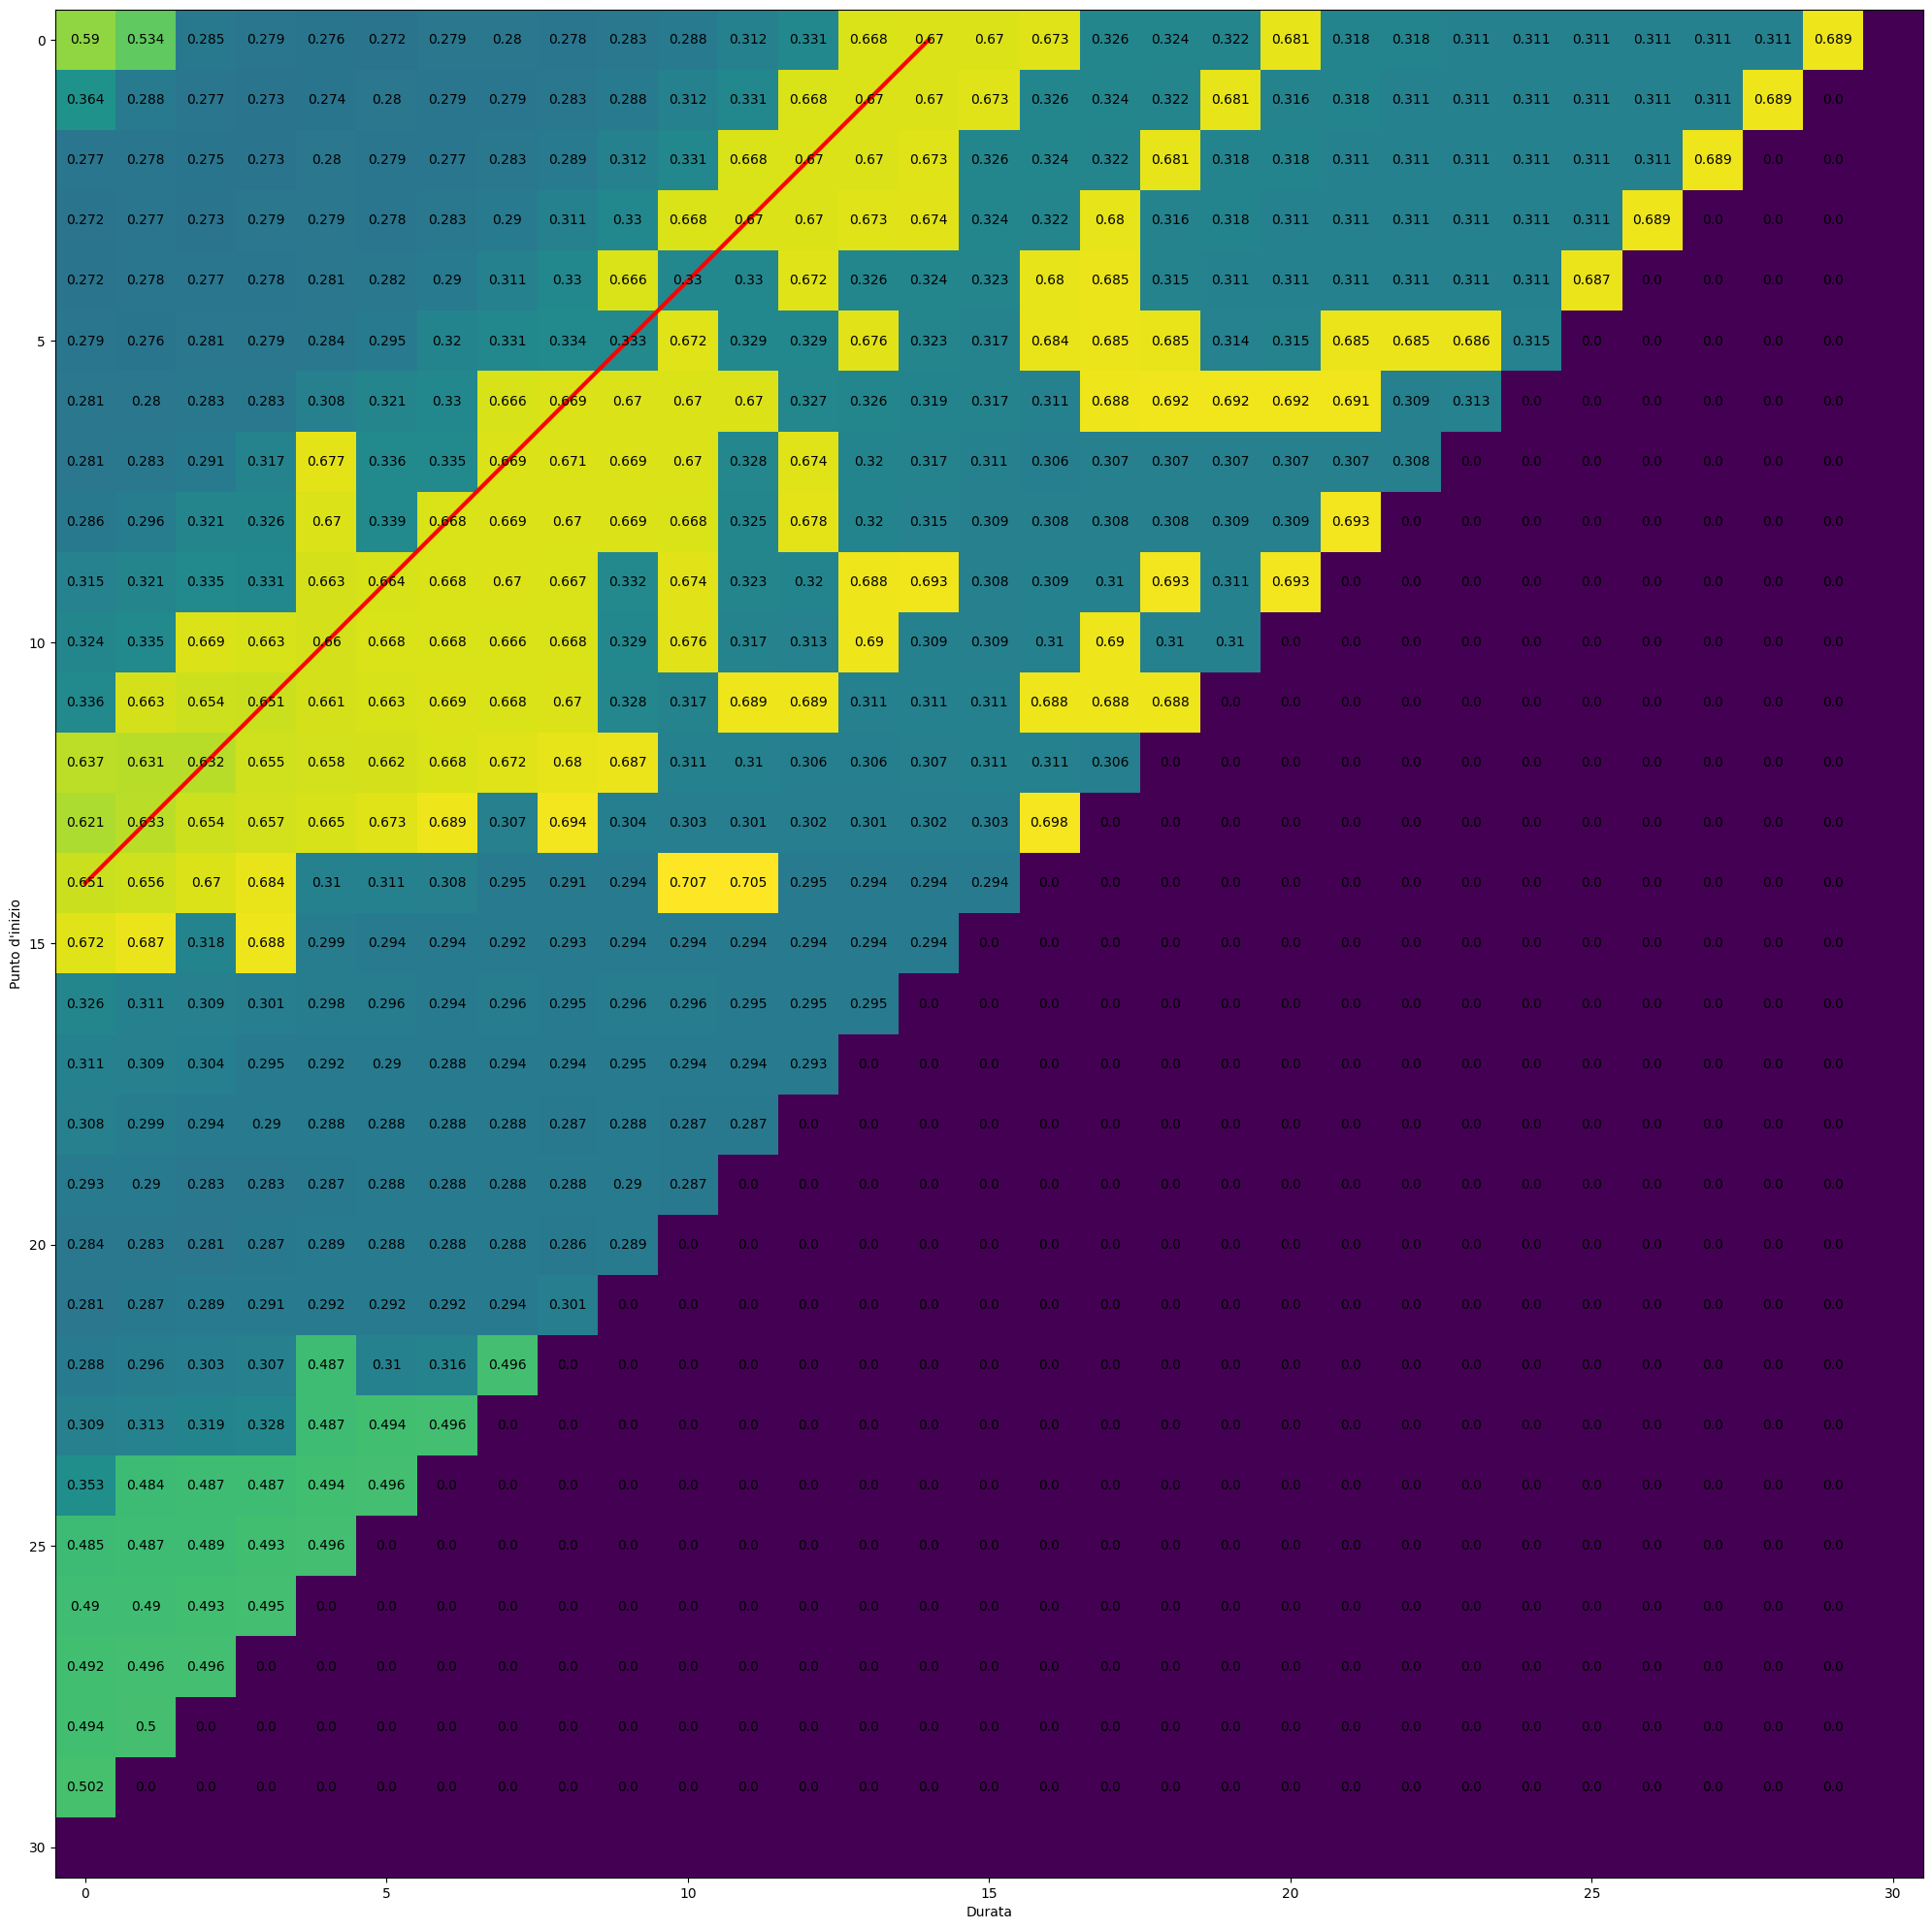

In [182]:
fig, ax = plt.subplots()
image = ax.imshow(matrice_accuracy[:,:])
line_start = [0, np.floor(71/5)]
line_end = [np.floor(71/5), 0]
plt.plot(line_start, line_end, color="red", linewidth=3)
plt.xlabel("Durata")
plt.ylabel("Punto d'inizio")

fig.set_size_inches(25,25)
for i in range(x):
    for j in range(y):
        c = np.round(matrice_accuracy[i,j],decimals=3)
        ax.text(j, i, str(c), va='center', ha='center')
plt.show()